## SARIMAで時系列予測を行う

In [1]:
# ライブラリーのインポート
import warnings
warnings.filterwarnings('ignore')

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly
init_notebook_mode(connected=True)
save_image = None # 'png' if save image

#### データの準備

In [2]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('../data/AirPassengers.csv')

# float型に変換
df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [3]:
df.dtypes

Passengers    float64
dtype: object

#### 時系列データの可視化

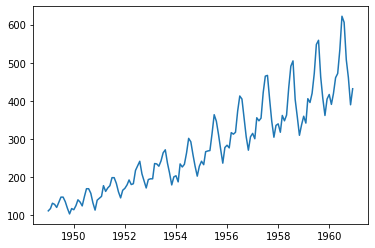

In [4]:
plt.plot(df.Passengers)
plt.show()

#### コレログラム

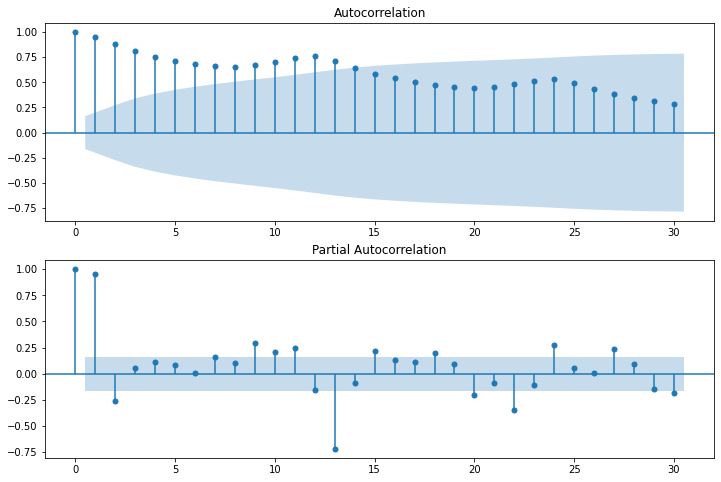

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.Passengers, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.Passengers, lags=30, ax=ax2)

#### 定常性の確認

* [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) を用いて、Dickey-Fuller 検定を行う
* Passengers: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない

In [6]:
res = sm.tsa.stattools.adfuller(df.Passengers)
print('p-value = {:.4}'.format(res[1]))

p-value = 0.9919


#### 成分分解

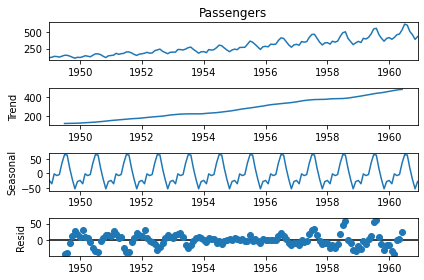

In [7]:
res = sm.tsa.seasonal_decompose(df["Passengers"])
fig = res.plot()

#### 差分系列データ

<AxesSubplot:xlabel='Month'>

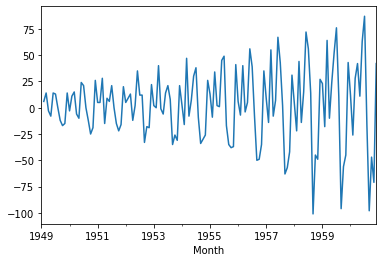

In [8]:
df_diff = df["Passengers"].diff(periods = 1)
df_diff.plot()

#### 対数変換データ

In [9]:
df_log = np.log(df["Passengers"])
df_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: Passengers, dtype: float64

<AxesSubplot:xlabel='Month'>

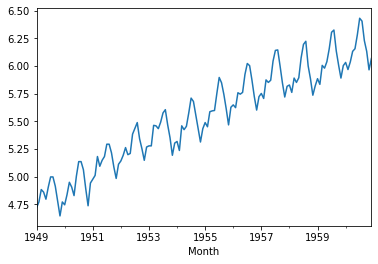

In [10]:
df_log.plot()

#### 対数差分系列変換データ

<AxesSubplot:xlabel='Month'>

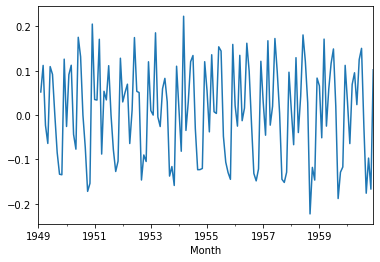

In [11]:
df_log_diff = df_log.diff(periods = 1)
df_log_diff.plot()

#### 差分系列＋季節調整済みデータ（=前年差）

<AxesSubplot:xlabel='Month'>

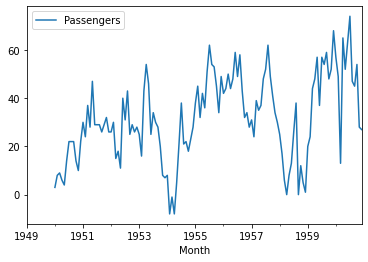

In [12]:
# 周期性：periods = 12として季節差分
df_sdiff = df.diff(periods = 12)
df_sdiff.plot()

#### 前年差の差分系列

<AxesSubplot:xlabel='Month'>

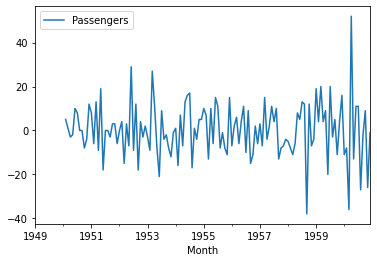

In [13]:
df_sdiff2 = df_sdiff.diff()
df_sdiff2.plot()

#### 定常性の確認

* [adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) を用いて、Dickey-Fuller 検定を行う
* df_sdiff2: p-value < 0.1 なので有意水準10%で帰無仮説が棄却され、定常を満たす

In [14]:
# NaNを削除
df_sdiff2 = df_sdiff2.dropna(how='all')

res = sm.tsa.stattools.adfuller(df_sdiff2.Passengers)
print('p-value = {:.4}'.format(res[1]))

p-value = 1.857e-28


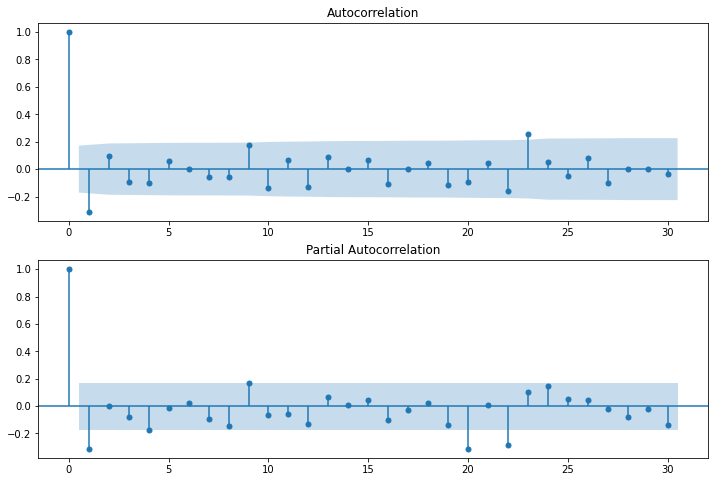

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sdiff2.Passengers, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sdiff2.Passengers, lags=30, ax=ax2)

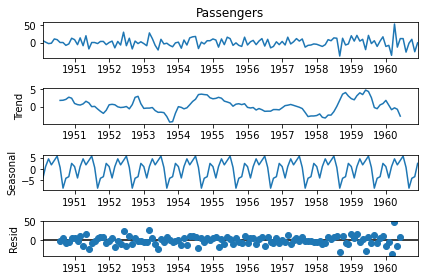

In [16]:
res = sm.tsa.seasonal_decompose(df_sdiff2["Passengers"])
fig = res.plot()

## SARIMA構築

In [17]:
# 学習と評価データに分割
df_train = df[df.index < '1957-04-01']
df_test = df[df.index >= '1957-04-01']

In [18]:
ts = df.Passengers
ts_train = df_train.Passengers
ts_test = df_test.Passengers

#### arma_order_select_ic
- [arma_order_select_ic](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html) を用いて、パラメータを決定
- AIC min: p=4, q=3

In [19]:
warnings.filterwarnings('ignore')

df_sdiff2_train = df_sdiff2[df_sdiff2.index < '1957-04-01']
res = sm.tsa.arma_order_select_ic(df_sdiff2_train, max_ar=7, max_ma=7, ic='aic')
res.aic_min_order

(4, 3)

In [20]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci

In [21]:
order=(4,1,3)
seasonal_order=(1,1,1,12)
model = SARIMAX(
    ts_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
result.summary()

RMSE(train):	17.811
RMSE(test):	27.347


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Passengers   No. Observations:                   99
Model:             SARIMAX(4, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -256.948
Date:                              Sun, 09 May 2021   AIC                            533.896
Time:                                      00:12:43   BIC                            556.381
Sample:                                  01-01-1949   HQIC                           542.827
                                       - 03-01-1957                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      1.713      0.550      0.582      -2.415       4.298
ar.L2         -0.6290      1.746     -0.360      0.719      -4.052       2.794
ar.L3          0.2346      0.893      0.263      0.793      -1.516       1.985
ar.L4          0.0459      0.240      0.191      0.848      -0.425       0.517
ma.L1         -1.1814      1.706     -0.692      0.489      -4.525       2.162
ma.L2          0.7785      2.027      0.384      0.701      -3.194       4.751
ma.L3         -0.4780      1.035     -0.462      0.644      -2.507       1.550
ar.S.L12      -0.0031      0.114     -0.028      0.978      -0.226       0.220
ma.S.L12      -0.2706      0.186     -1.458      0.145      -0.634       0.093
sigma2        87.7149     16.810      5.218      0.000      54.767     120.662
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.86
Prob(Q):                              0.91   Prob(JB):                         0.39
Heteroskedasticity (H):               1.12   Skew:                             0.40
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
train_pred = result.predict()
test_pred = result.forecast(len(ts_test))

In [23]:
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()
print(test_pred_ci)

            lower Passengers  upper Passengers
1957-04-01        332.810025        369.522605
1957-05-01        333.264567        379.387745
1957-06-01        381.084026        433.606452
1957-07-01        419.031766        474.915068
1957-08-01        408.224350        466.029675
1957-09-01        361.827795        421.180550
1957-10-01        315.929519        376.773198
1957-11-01        280.382999        342.569780
1957-12-01        315.097539        378.411843
1958-01-01        323.056877        387.362569
1958-02-01        310.347743        375.606641
1958-03-01        360.533641        426.737169
1958-04-01        351.175308        427.372226
1958-05-01        352.964687        435.294298
1958-06-01        401.673719        488.979424
1958-07-01        439.848777        530.570411
1958-08-01        428.836722        522.081475
1958-09-01        382.026197        477.513756
1958-10-01        335.735914        433.397360
1958-11-01        299.867788        399.574309
1958-12-01   

In [24]:
train_rmse = np.sqrt(mean_squared_error(df_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test, test_pred))
print('RMSE(train): {:.5}\nRMSE(test): {:.5}'.format(train_rmse, test_rmse))

RMSE(train): 17.811
RMSE(test): 27.347


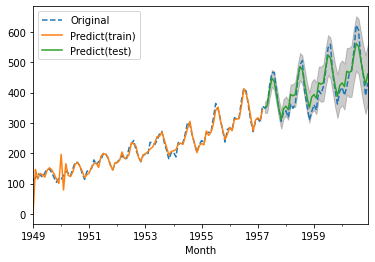

In [25]:
fig, ax = plt.subplots()
df.Passengers.plot(ax=ax, label='Original', linestyle="dashed")
train_pred.plot(ax=ax, label='Predict(train)')
test_pred.plot(ax=ax, label='Predict(test)')
ax.fill_between(
    test_pred_ci.index,
    test_pred_ci.iloc[:, 0],
    test_pred_ci.iloc[:, 1],
    color='k',
    alpha=.2)
ax.legend()